# Exmamining the TCR Beta Chain Repertoire Through Time

This notebook explores various aspects of TCR repertoire structure, using a dataset from Adaptive Biotechnologies (https://clients.adaptivebiotech.com). The dataset is called "TCRB Time Course" and includes data from 3 individuals samples over multiple months for a full year. For all time points, PBMCs were collected and analyzed using bulk beta-chain sequencing, and for 2 time points for each individual, PBMCs, naive, and memory T cell subsets were sequenced.

As a first step, let's look at PBMCs from one individual at one time point and ask a few basic questions:

1. Does the number of unique TCR nucleotides encoding a given clonotype (i.e., different TCR lineages that result in the same TCR amino acid sequence) covary with the frequency of that clonotype?

2. What subset of PBMC TCRs also occur in the memory subset?

In [3]:
#ONLY IF USING A SERVER (SET DISPLAY SETTINGS)
import matplotlib
matplotlib.use('AGG')

In [1]:
import matplotlib.pyplot as plt, matplotlib_venn as plt_venn, random
import pandas as pd, numpy as np, seaborn as sns, skbio.diversity as div
from collections import Counter, defaultdict
from math import exp
from skbio.stats import subsample_counts
from glob import glob
from itertools import combinations_with_replacement, count
from datetime import datetime
from scipy.stats import norm, kstest, spearmanr
from matplotlib.backends.backend_pdf import PdfPages
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
def plot_ind_freq(frequency_list, log=False, descending=True):
  """
  For a given list of frequencies, plots each frequency in order. This script
  helps visualize the decay of frequencies of things like TCRs
  """
  if descending:
    frequency_list = sorted(frequency_list, reverse=True)
  else:
    frequency_list = sorted(frequency_list)
  x_val = range(len(frequency_list))
  plt.scatter(x_val, frequency_list, facecolors='none', edgecolors='grey')
  if log:
    plt.yscale('log')

In [3]:
def gene_segment_count(df, gene_col, groupby_col):
    """
    This script is for counting the number of gene segments (i.e. VDJ segments)
    associated with each TCR clonotype.
    
    Takes a dataframe, groups the rows by the column grouby_col, and then for
    each of these subtables, counts the number of unique entries in the column
    gene_col
    
    returns a dictionary with keys being the unique elements in groupby_col and 
    the keys being the number of unique entries in gene_col associated with
    each element.
    """
    gene_allele_counts = {}
    for clonotype, subdf in df.groupby(groupby_col):
        gene_allele_counts[clonotype] = subdf[gene_col].nunique()
    return gene_allele_counts

In [4]:
def col_comb_rename(df, groupby_cols, id_col, drop=True, name='tcr_'):
    """
    This script takes a dataframe, and creates a new column (id_col) that contains a unique
    ID for every combination of values in the groupby_cols. The unique IDs are prefixed
    by the variable 'name.'
    
    Return a table with this new column, and removes the groupby_cols if drop=True
    
    For example, if three columns are ['vMaxResolved', 'jMaxResolved', 'aminoAcid'],
    this function would return a dataframe with a unique ID representing each unique
    combination of these three columns (a TCR epitope)
    """
    id_dict = {}
    comb_series = df[groupby_cols].apply(tuple, axis=1)
    num_gen = count(start=0, step=1)
    for col_tuple in comb_series.unique(): #get a dictionary of labels
        id_dict[col_tuple] = name + str(next(num_gen))
    df[id_col] = comb_series.apply(lambda x: id_dict[x])
    if drop:
        df = df.drop(groupby_cols, axis=1)
    return df, {v: k for k, v in id_dict.items()} #invert dictionary to have ids as keys

In [5]:
def df_collapse(df, group_by_cols, sum_col):
    """
    Accepts a dataframe and groups the dataframe by the columns in group_by_cols. 
    Returns a dataframe with the groupby columns and the summed output of sum_col, 
    which can either be a single column (as a list) or list of column names
    """
    df = df[group_by_cols + sum_col]
    return df.groupby(group_by_cols).sum().reset_index()

In [6]:
def rarefaction_curve(vector_counts, num_points, log=False):
    """
    From a vector of counts, plots the number of new species observed versus
    the number sequences sampled.
    
    Not deterministic, so each curve will be slightly different
    
    num_points is the number of points between 1 and the total counts in
    vector_counts that will be evaluated.
    
    If the log option is flagged, will use points that are logarithmically
    spaced along the possible counts
    """
    vector_counts = np.array(vector_counts) #make sure the vector is an array
    count_total = np.sum(vector_counts)
    
    if log:
        x = np.logspace(0, np.log10(count_total), num=num_points)
    else:
        x = np.linspace(1, count_total, num=num_points)
    subsamples = [subsample_counts(vector_counts, int(n)) for n in x]
    y = np.array([np.count_nonzero(subsam) for subsam in subsamples])
    sns.regplot(x, y, fit_reg=False)
    
    return x, y

In [7]:
def adaptive_error_filter(adaptive_tab, sample_col, min_threshold=-15, num_samples=2):
    """
    This function filters an adaptive table for particularly rare species that
    are likely sequencing errors. Based on the data, it only considers species
    with frequencies lower than exp(min_threshold) as potential errors
    
    It will only retain those rare species that occur in at least num_samples
    samples, which are defined by the entries in the column sample_col
    
    Returns a filtered table
    """
    rare_table = adaptive_tab.loc[adaptive_tab['frequencyCount (%)'] <= exp(min_threshold)]
    common_table = adaptive_tab.loc[adaptive_tab['frequencyCount (%)'] > exp(min_threshold)]
    tcr_list = []
    for sample, sample_tab in rare_table.groupby(sample_col):
        tcr_list.extend(set(sample_tab['aminoAcid']))
    rare_tcr_counts = Counter(tcr_list)
    passing_tcrs = []
    for key, val in rare_tcr_counts.items():
        if val >= num_samples:
            passing_tcrs.append(key)
    return pd.concat([common_table, 
                      rare_table.loc[rare_table['aminoAcid'].isin(passing_tcrs)]])

In [11]:
def plot_freq_comparison(x_series, y_series, log=True, spearman=True, return_axes=True):
    """
    Takes two series, which are assumed to be the same type of values and 
    plot the two against each other.
    
    The two series either must have identical indexes OR have indexes that
    are related, and thus comparison of each index is valid
    
    Log will plot both axes using a log scale
    Spearman will annotate the figure with the # of shared elements, spearman rho, and p val
    Return axes will return the axes object
    """
    tmp_table = pd.concat([x_series, y_series], axis=1)
    tmp_table = tmp_table.fillna(0) #fill missing values with zero
    fig = plt.figure()
    plt.scatter(tmp_table.iloc[:, 0].values, tmp_table.iloc[:, 1].values,
                facecolors='none', edgecolors='grey')
    plot_max = max([x_series.max(), y_series.max()])
    linthresh = min([x_series.min(), y_series.min()])
    if log:
        plt.xscale('symlog', linthreshx=linthresh)
        plt.yscale('symlog', linthreshy=linthresh)
    plt.xlim(0, plot_max)
    plt.ylim(0, plot_max)
    sns.despine()
    
    #calculate spearman correlation and report
    if spearman:
        tmp_table = tmp_table[~(tmp_table == 0).any(axis=1)] #keep only shared tcrs
        rho, pval = spearmanr(tmp_table.iloc[:, 0].values, 
                              tmp_table.iloc[:, 1].values)
        plt.annotate('shared tcrs = {0}, rs = {1:.5f}, p = {2:.5f}'.format(len(tmp_table.index), rho, pval), 
                     xy=(1,0.05), xycoords='axes fraction', 
                     horizontalalignment='right', verticalalignment='bottom')
    if return_axes:
        return fig

## Do more common TCRs tend to be encoded by multiple nucleotide rearrangements?

A single CDR3 amino acid sequence or VDJ rearrangement can be encoded by multiple nucleotide sequences, largely because of codon redundancy. Do we find that CDR3 sequences with greater frequency have multiple nucleotides encoding them? If yes, this would suggest that the abundance of CDR3 is partly or largely due to chance. It also might suggest that T cell selection is operating on the amino acid sequence, thus increasing the frequency of multiple distint clonotypes, which might have the same end antigen-response phenotype.

In [4]:
sub1_pbmc = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01_110819_PBMC_cl1.tsv',
                       sep='\t')
#NOTE: this file has been cleaned of unproductive TCRs and TCRs that did not map to a V or J gene
metadata = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/tcrb_timecourse_metadata.txt',
                     sep='\t')

In [55]:
print('This table represents ' + str(sub1_pbmc['frequencyCount (%)'].sum()) + ' of total TCR sequences')
sub1_pbmc.head()

This table represents 0.6194230865692629 of total TCR sequences


,nucleotide,aminoAcid,frequencyCount (%),cdr3Length,vMaxResolved,dMaxResolved,jMaxResolved
0,ACTCTGAAGATCCGGTCCACAAAGCTGGAGGACTCAGCCATGTACT...,CASSNNEKLFF,0.000007,33,TCRBV02-01*01,unresolved,TCRBJ01-04*01
1,CCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACT...,CASSSSYEQYF,0.000007,33,TCRBV27-01*01,unresolved,TCRBJ02-07*01
2,ACTCTGAAGATCCGGTCCACAAAGCTGGAGGACTCAGCCATGTACT...,CASSGAEKLFF,0.000007,33,TCRBV02-01*01,unresolved,TCRBJ01-04*01
3,CTCCTCACTCTGGAGTCCGCTACCAGCTCCCAGACATCTGTGTACT...,CAISESYGYTF,0.000006,33,TCRBV10-03*01,unresolved,TCRBJ01-02*01
4,ACTCTGAAGATCCAGCCTGCAGAGCAGGGGGACTCGGCCGTGTATG...,CASRLNTEAFF,0.000005,33,TCRBV12-02*01,unresolved,TCRBJ01-01*01


In [19]:
rearrange_dict = Counter(sub1_pbmc['aminoAcid'])
#get a table of frequencies if you collapse nucleotides with the same aminoAcid TCR
#equivalent to collapsing by 'clonotype'
freq_df = sub1_pbmc[['aminoAcid', 'frequencyCount (%)']].groupby(sub1_pbmc['aminoAcid']).sum()
freq_dict = freq_df['frequencyCount (%)'].to_dict()

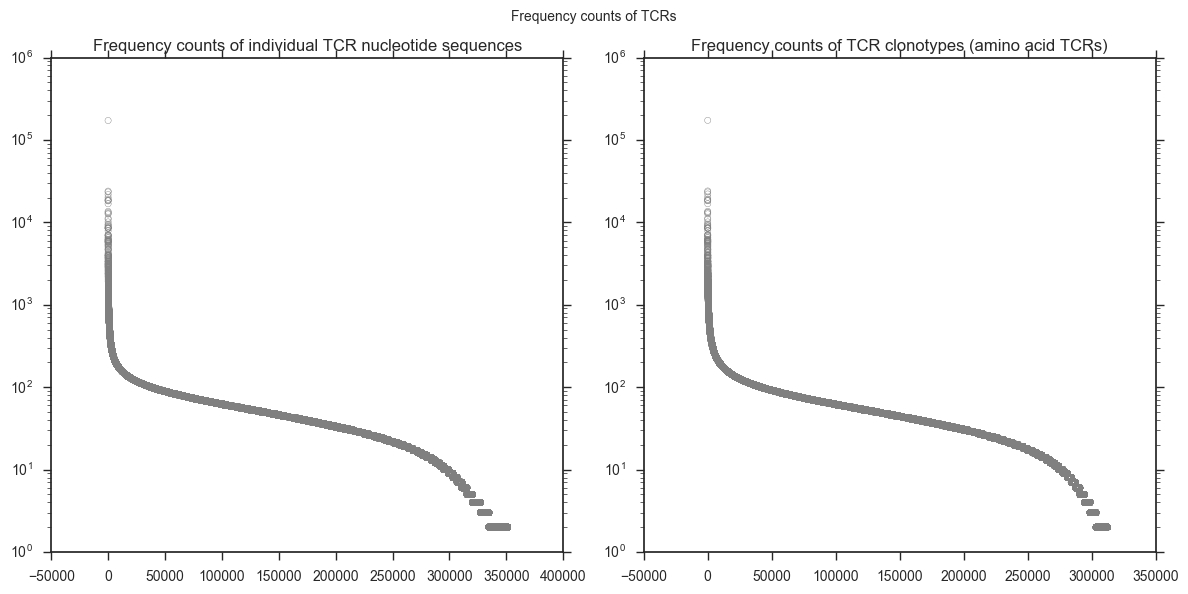

In [52]:
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Frequency counts of TCRs")
ax = fig.add_subplot(1,2,1)
plot_ind_freq(sub1_pbmc['frequencyCount (%)'] * 31359887, log=True)
plt.title("Frequency counts of individual TCR nucleotide sequences")
ax = fig.add_subplot(1,2,2)
plot_ind_freq(freq_df['frequencyCount (%)'] * 31359887, log=True)
plt.title("Frequency counts of TCR clonotypes (amino acid TCRs)")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

These curves look very similar, suggesting that collapsing multiple nucleotides into their CDR3 aminoacid sequence doesn't really change the structure of the TCR that much.

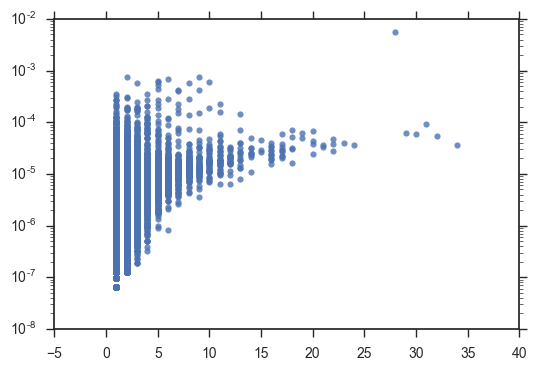

In [48]:
clonotypes = rearrange_dict.keys()
x_num_nucleo = np.array([rearrange_dict[x] for x in clonotypes])
y_freq = np.array([freq_dict[x] for x in clonotypes])
sns.regplot(x_num_nucleo, y_freq, fit_reg=False)
plt.yscale('log')

So if we look at this single time point from this individual, it does look like having multiple nucleotide rearrangements generally correlates with having a greater overall frequency of the resulting TCR. This could suggest that selection for TCRs is lifting the abundances of multiple TCR lineages that share a common TCR, or this could be a product of pure chance. Multiple nucleotide sequences captures 2 primary factors: 1) the fact that a given amino acid TCR can be encoded by multiple DNA sequences and 2) the each TCR can be paired with multiple V, D, and J segments.

Furthermore, each nucleotide observation is associated with many different V, D, and J segments, meaning that collapsing T cells by the CDR3 aminoAcid sequence is unlikely to be a valid choice.

In [69]:
sub1_pbmc.loc[sub1_pbmc['aminoAcid'] == 'CASSSSYEQYF'].head(3)

,nucleotide,aminoAcid,frequencyCount (%),cdr3Length,vMaxResolved,dMaxResolved,jMaxResolved
1,CCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACT...,CASSSSYEQYF,6.919668e-06,33,TCRBV27-01*01,unresolved,TCRBJ02-07*01
7735,CCGCTCAGGCTGGAGTTGGCTGCTCCCTCCCAGACATCTGTGTACT...,CASSSSYEQYF,6.377574e-08,33,TCRBV06-06,TCRBD02-01,TCRBJ02-05*01
19902,CCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACT...,CASSSSYEQYF,9.566361e-08,33,TCRBV27-01*01,TCRBD02-01,TCRBJ02-05*01


The fact that there is a lot of information at the nucleotide level (although perhaps not in the nucleotide sequence itself), indidcates that we should use full tables, but just cut the nucleotide column. For this table, removing nucleotide information results in saving about 50% of the file size.

In [62]:
sub1_pbmc[['aminoAcid', 'frequencyCount (%)', 'cdr3Length', 'vMaxResolved', 'dMaxResolved', 'jMaxResolved']].to_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01_110819_PBMC_cl2.tsv',
                       sep='\t')

So how many V, D, and J segments is a given TCR paired with?

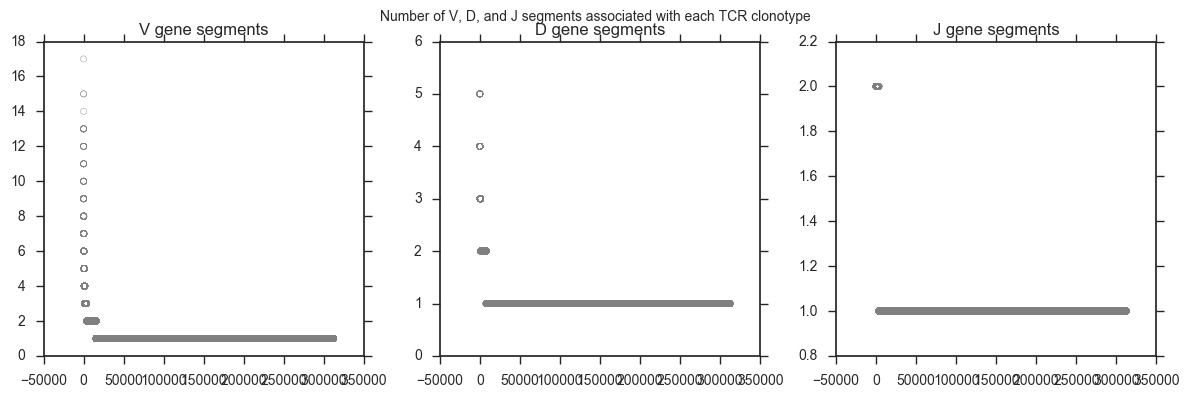

In [70]:
fig = plt.figure(figsize=(12, 4))
plt.suptitle("Number of V, D, and J segments associated with each TCR clonotype")
ax = fig.add_subplot(1,3,1)
plot_ind_freq(gene_segment_count(sub1_pbmc, 'vMaxResolved', 'aminoAcid').values())
plt.title("V gene segments")
ax = fig.add_subplot(1,3,2)
plot_ind_freq(gene_segment_count(sub1_pbmc, 'dMaxResolved', 'aminoAcid').values())
plt.title("D gene segments")
ax = fig.add_subplot(1,3,3)
plot_ind_freq(gene_segment_count(sub1_pbmc, 'jMaxResolved', 'aminoAcid').values())
plt.title("J gene segments")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

Evidently, the vast majority of clonotypes are paired with only one V, D, or J segment, although the combination could be more varied. Does each clonotype need to be considered in it's V, J context as a separate clonotype? Are they the same clonotype if the V and J segments are different? Probably not; they should be considered independent clonotypes.

## Examining the naive and memory compartments of the TCR repertoire

Theoretically, naive T cells should be the most diverse population of T cell, as no expansions or peripheral antigen selection has occured. The memory T cell population ought to be less diverse, given that these are T cells that have encountered their cognate antigen before. How does this play out in this dataset?

In [ ]:
%reset #resets current variables

In [160]:
pbmc_sam = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01-110819_PBMC_cl1.tsv',
                      sep='\t')
pbmc_sam.drop('nucleotide', inplace=True, axis=1) #drop nucleotides to save memory
naive_sam = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01-110819_Naive_cl1.tsv',
                      sep='\t')
naive_sam.drop('nucleotide', inplace=True, axis=1)
memory_sam = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01-110819_Memory_cl1.tsv',
                      sep='\t')
memory_sam.drop('nucleotide', inplace=True, axis=1)

In [50]:
cnt_vctrs = [pbmc_sam['count (templates/reads)'].values,
             naive_sam['count (templates/reads)'].values,
             memory_sam['count (templates/reads)'].values]
rare_vctrs = [subsample_counts(x, 9000000) for x in cnt_vctrs]

A basic question is what level to collapse various TCRs? Beyond more complex means, a few simple options are available:

1. Each nucleotide sequence is a clonotype ("Nucleotide"). This primarily represents different DNA sequences that encode the same amino acid sequence from codon redundancy.
2. Each combination of V, J and CDR3 amino acid sequence is a clonotype ("VJ_CDR3"). This is the full amino acid sequence that see the eventual antigen/MHC complex.
3. Each CDR3 amino acid sequence is a clonotype ("CDR3). This is the specific region believed to be most important for antigen interaction/engagement.

We'll look at alpha diversity among these three T cell populations using each of these methods. We can also test whether rarefaction does anything significant to the data.

A good discussion on TCR alpha diversity is [here](https://www.ncbi.nlm.nih.gov/pubmed/26150657).

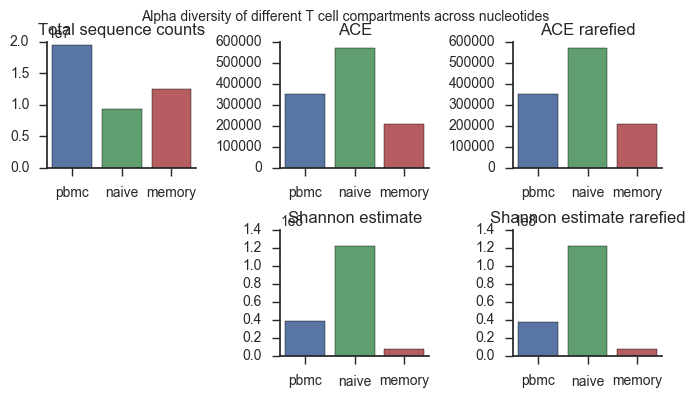

In [127]:
fig = plt.figure(figsize=(7, 4))
plt.suptitle('Alpha diversity of different T cell compartments across nucleotides')

ax = fig.add_subplot(2,3,1)
x = ['pbmc', 'naive', 'memory']
y = [np.sum(vector) for vector in cnt_vctrs]
sns.barplot(x, y)
plt.title("Total sequence counts")

ax = fig.add_subplot(2,3,2)
y = [div.alpha.ace(vector) for vector in cnt_vctrs]
sns.barplot(x, y)
plt.title("ACE")

ax = fig.add_subplot(2,3,5)
y = [exp(div.alpha.shannon(vector)) for vector in cnt_vctrs]
sns.barplot(x, y)
plt.title("Shannon estimate")

ax = fig.add_subplot(2,3,3)
y = [div.alpha.ace(vector) for vector in rare_vctrs]
sns.barplot(x, y)
plt.title("ACE rarefied")

ax = fig.add_subplot(2,3,6)
y = [exp(div.alpha.shannon(vector)) for vector in rare_vctrs]
sns.barplot(x, y)
plt.title("Shannon estimate rarefied")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
sns.despine()

Clearly rarefaction does very little to the output of these metrics, although with TCRs it looks like ACE and potentially all estimators of species richness will converge on the observed number of TCRs because the data is so diverse. We can largely split different types of alpha diversity into two camps: estimators of richness (ACE, Chao1) and estimators of richness/eveness (Shannon, Simpson). For TCRs, it seems like we actually largely care about estimators of richness, although a heavier tail of expanded clones might indicate T cells that were most recently antagonized.

If we look at each combination of V CDR3 and J segments, the alpha diversity picture looks like this:

In [67]:
#calculate counts for VJ-CDR3 combinations
vj_cdr3_tbl_pbmc = vd_cdr3_comb(pbmc_sam, 'count (templates/reads)')
vj_cdr3_tbl_naive = vd_cdr3_comb(naive_sam, 'count (templates/reads)')
vj_cdr3_tbl_memory = vd_cdr3_comb(memory_sam, 'count (templates/reads)')

#get vectors of the counts
cnt_vctrs_vjcdr3 = [vj_cdr3_tbl_pbmc['count (templates/reads)'].values, 
                    vj_cdr3_tbl_naive['count (templates/reads)'].values, 
                    vj_cdr3_tbl_memory['count (templates/reads)'].values]

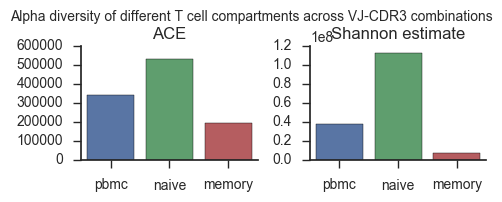

In [70]:
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Alpha diversity of different T cell compartments across VJ-CDR3 combinations')

ax = fig.add_subplot(1,2,1)
x = ['pbmc', 'naive', 'memory']
y = [div.alpha.ace(vector) for vector in cnt_vctrs_vjcdr3]
sns.barplot(x, y)
plt.title("ACE")

ax = fig.add_subplot(1,2,2)
y = [exp(div.alpha.shannon(vector)) for vector in cnt_vctrs_vjcdr3]
sns.barplot(x, y)
plt.title("Shannon estimate")

plt.tight_layout()
plt.subplots_adjust(top=0.8)
sns.despine()

The overall pattern is still certainly dominante here. If we do our last permutation which is clustering solely on the aminoAcid cdr3 region:

In [74]:
#calculate counts for CDR3 amino acid sequences
aa_tbl_pbmc = pbmc_sam[['aminoAcid', 'count (templates/reads)']].groupby('aminoAcid').sum().reset_index()
aa_tbl_naive = naive_sam[['aminoAcid', 'count (templates/reads)']].groupby('aminoAcid').sum().reset_index()
aa_tbl_memory = memory_sam[['aminoAcid', 'count (templates/reads)']].groupby('aminoAcid').sum().reset_index()

#get vectors of the counts
cnt_vctrs_aa = [aa_tbl_pbmc['count (templates/reads)'].values, 
                aa_tbl_naive['count (templates/reads)'].values, 
                aa_tbl_memory['count (templates/reads)'].values]

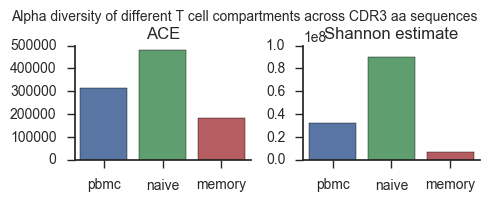

In [75]:
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Alpha diversity of different T cell compartments across CDR3 aa sequences')

ax = fig.add_subplot(1,2,1)
x = ['pbmc', 'naive', 'memory']
y = [div.alpha.ace(vector) for vector in cnt_vctrs_aa]
sns.barplot(x, y)
plt.title("ACE")

ax = fig.add_subplot(1,2,2)
y = [exp(div.alpha.shannon(vector)) for vector in cnt_vctrs_aa]
sns.barplot(x, y)
plt.title("Shannon estimate")

plt.tight_layout()
plt.subplots_adjust(top=0.8)
sns.despine()

### Are all of these sequences/diversity real?
In [Warren et al. 2011](http://genome.cshlp.org/content/early/2011/02/23/gr.115428.110.abstract), the authors suggest that they achieve saturation at about 14 million reads. They empirically found that only those sequences comprising 96% of the total sequence count were true sequences, the rest were errors. They did this by looking at the J segment reads.

I don't really want to parse out the J segment parts of these reads, so we can take an alternate route, which is to plot rarefaction curves using different cutoffs of the volume of data. We might expect a saturation of perhaps ~300-500,000 different TCRs.

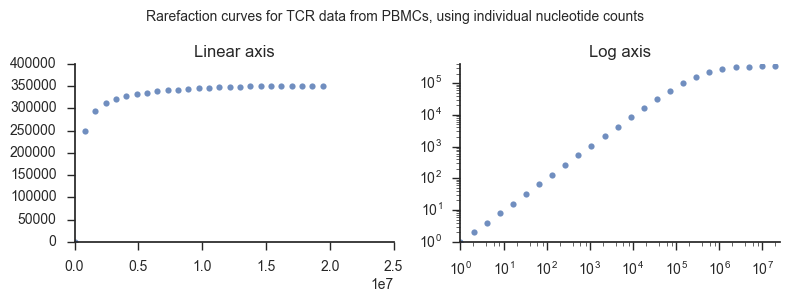

In [122]:
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Rarefaction curves for TCR data from PBMCs, using individual nucleotide counts')

ax = fig.add_subplot(1,2,1)
plt.title("Linear axis")
tmpx, tmpy = rarefaction_curve(pbmc_sam['count (templates/reads)'], 25)
plt.xlim(0, None)
plt.ylim(0, None)

ax = fig.add_subplot(1,2,2)
plt.title("Log axis")
tmpx, tmpy = rarefaction_curve(pbmc_sam['count (templates/reads)'], 25, log=True)
plt.xlim(1, None)
plt.ylim(1, None)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.subplots_adjust(top=0.8)
sns.despine()

So by rarefaction, we get saturation pretty early in sampling, but it's still suspect whether all of these new sequences actually represent new TCRs, since we don't have a validated sample set that we can compare to.


## Overlap between T cell compartments

In a similar manner to alpha diversity, the overlap between compartments can also be done using unique nucleotide sequences, VJ_CDR3 combinations, or CDR3 amino acid sequence. We'll focus on the latter two, since this is likely more important for antigen response, and because the nucleotide sequences take up a bunch of memory.

First let's look at the CDR3 region only (no VJ context)

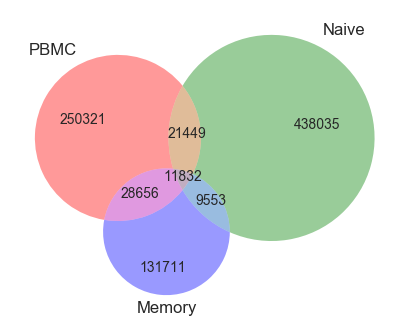

In [80]:
plt_venn.venn3([set(pbmc_sam['aminoAcid']), set(naive_sam['aminoAcid']), set(memory_sam['aminoAcid'])],
              set_labels = ('PBMC', 'Naive', 'Memory'))

This result is a little surprising, given that my *a priori* expection is that Naive cells would encompass many/most of the Memory cells. However, the diversity of the TCR repertoire might be so high that different samples (either blood samples or T cell subsets) as well as different library preps might result in appreciably different T cell populations.

The overlap between these groups is pretty high, in some cases almost 10-20% of the total sequences in a single population.

1. Is this overlap by chance?

If so, we would expect the distribution of counts/frequencies to be about the same for the overlapping population as the total population. If not, then we would expect the overlapping population to be enriched for TCRs with greater frequencies. In other words, the TCRs are real TCRs and appear to be more abundant because of clonal expansion, particularly in the case of overlap with the Memory population.

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


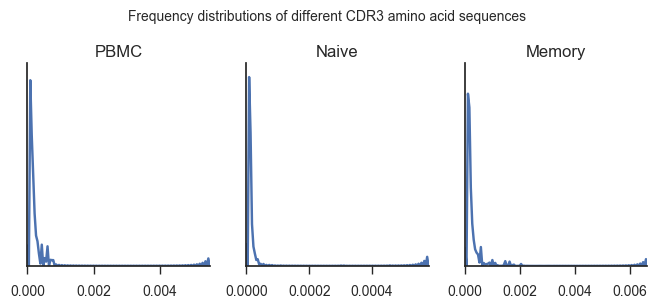

In [163]:
#look at TCR amino acid frequencies in each of the subsets from the venn diagram above
aa_tbl_pbmc_freq = pbmc_sam[['aminoAcid', 'frequencyCount (%)']].groupby('aminoAcid').sum().reset_index()
aa_tbl_naive_freq = naive_sam[['aminoAcid', 'frequencyCount (%)']].groupby('aminoAcid').sum().reset_index()
aa_tbl_memory_freq = memory_sam[['aminoAcid', 'frequencyCount (%)']].groupby('aminoAcid').sum().reset_index()

fig = plt.figure(figsize=(8, 3))
plt.suptitle('Frequency distributions of different CDR3 amino acid sequences')

ax1 = fig.add_subplot(1,3,1)
plt.title('PBMC')
sns.kdeplot(aa_tbl_pbmc_freq['frequencyCount (%)'].values)
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(1,3,2)
plt.title('Naive')
sns.kdeplot(aa_tbl_naive_freq['frequencyCount (%)'].values)
ax2.yaxis.set_visible(False)
ax2.locator_params(axis='x', tight=True, nbins=5)

ax3 = fig.add_subplot(1,3,3)
plt.title('Memory')
sns.kdeplot(aa_tbl_memory_freq['frequencyCount (%)'].values)
ax3.yaxis.set_visible(False)
ax3.locator_params(axis='x', tight=True, nbins=5)

sns.despine()
plt.subplots_adjust(top=0.8)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


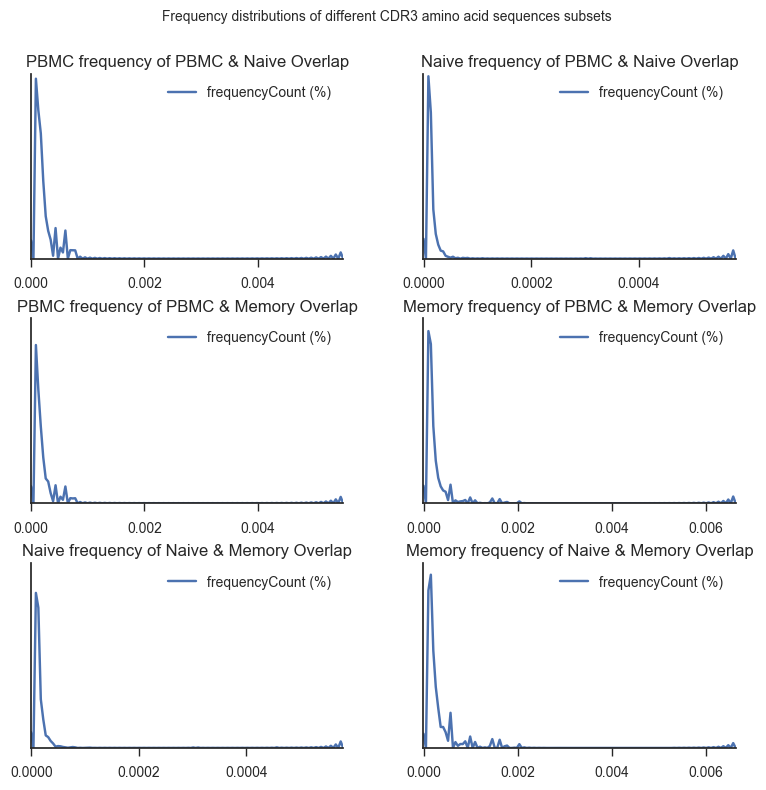

In [166]:
pbmc_naive_ovrlp = set(pbmc_sam['aminoAcid']).intersection(set(naive_sam['aminoAcid']))
pbmc_mem_ovrlp = set(pbmc_sam['aminoAcid']).intersection(set(memory_sam['aminoAcid']))
naive_mem_ovrlp = set(naive_sam['aminoAcid']).intersection(set(memory_sam['aminoAcid']))

fig = plt.figure(figsize=(8, 8))
plt.suptitle('Frequency distributions of different CDR3 amino acid sequences subsets')

ax1 = fig.add_subplot(3,2,1)
plt.title('PBMC frequency of PBMC & Naive Overlap')
tmp_subtab = aa_tbl_pbmc_freq.loc[aa_tbl_pbmc_freq['aminoAcid'].isin(pbmc_naive_ovrlp)]
sns.kdeplot(tmp_subtab['frequencyCount (%)'])
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax1 = fig.add_subplot(3,2,2)
plt.title('Naive frequency of PBMC & Naive Overlap')
tmp_subtab = aa_tbl_naive_freq.loc[aa_tbl_naive_freq['aminoAcid'].isin(pbmc_naive_ovrlp)]
sns.kdeplot(tmp_subtab['frequencyCount (%)'])
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax1 = fig.add_subplot(3,2,3)
plt.title('PBMC frequency of PBMC & Memory Overlap')
tmp_subtab = aa_tbl_pbmc_freq.loc[aa_tbl_pbmc_freq['aminoAcid'].isin(pbmc_mem_ovrlp)]
sns.kdeplot(tmp_subtab['frequencyCount (%)'])
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax1 = fig.add_subplot(3,2,4)
plt.title('Memory frequency of PBMC & Memory Overlap')
tmp_subtab = aa_tbl_memory_freq.loc[aa_tbl_memory_freq['aminoAcid'].isin(pbmc_mem_ovrlp)]
sns.kdeplot(tmp_subtab['frequencyCount (%)'])
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax1 = fig.add_subplot(3,2,5)
plt.title('Naive frequency of Naive & Memory Overlap')
tmp_subtab = aa_tbl_naive_freq.loc[aa_tbl_naive_freq['aminoAcid'].isin(naive_mem_ovrlp)]
sns.kdeplot(tmp_subtab['frequencyCount (%)'])
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax1 = fig.add_subplot(3,2,6)
plt.title('Memory frequency of Naive & Memory Overlap')
tmp_subtab = aa_tbl_memory_freq.loc[aa_tbl_memory_freq['aminoAcid'].isin(naive_mem_ovrlp)]
sns.kdeplot(tmp_subtab['frequencyCount (%)'])
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

The fact that these T cells have such low abundance (and that very few have a higher abundance) is making interpretation of these plots pretty difficult. Let's see what happens if we log-transform the data.

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


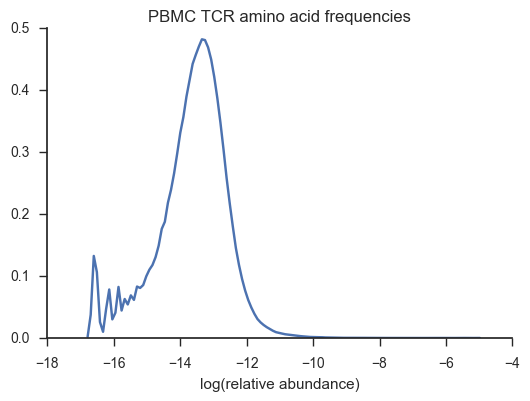

In [175]:
plt.title('PBMC TCR amino acid frequencies')
sns.kdeplot(np.log(aa_tbl_pbmc_freq['frequencyCount (%)'].values))
plt.xlabel('log(relative abundance)')
sns.despine()

So this looks a ton better than the super weird untransformed data. We can even see the prevalence of what's probably sequencing error at the low end, where we have abberant jumps in the distribution. It also shows that the most common frequency of TCR is somewhere aroun 1e-6. Let's do this for all of the T cell populations from this subject at this time point.

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


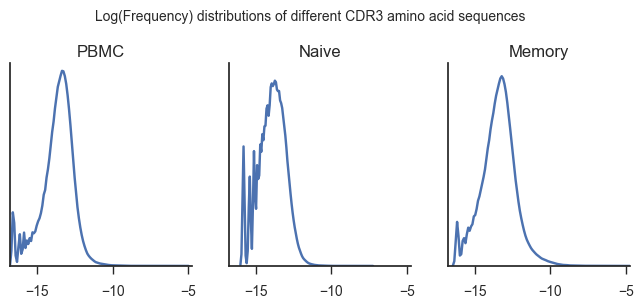

In [177]:
fig = plt.figure(figsize=(8, 3))
plt.suptitle('Log(Frequency) distributions of different CDR3 amino acid sequences')

ax1 = fig.add_subplot(1,3,1)
plt.title('PBMC')
sns.kdeplot(np.log(aa_tbl_pbmc_freq['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(1,3,2, sharex=ax1)
plt.title('Naive')
sns.kdeplot(np.log(aa_tbl_naive_freq['frequencyCount (%)'].values))
ax2.yaxis.set_visible(False)
ax2.locator_params(axis='x', tight=True, nbins=5)

ax3 = fig.add_subplot(1,3,3, sharex=ax1)
plt.title('Memory')
sns.kdeplot(np.log(aa_tbl_memory_freq['frequencyCount (%)'].values))
ax3.yaxis.set_visible(False)
ax3.locator_params(axis='x', tight=True, nbins=5)

sns.despine()
plt.subplots_adjust(top=0.8)

So log transforming the data also cleans up the data from the other cell populations. Interestingly, Memory cells do seem to have a higher average frequency than the others. Naive cells (perhaps due to the number of cells used for the library prep) looks noisier, particularly for low abundance TCRs. This might be affecting the alpha diversity metrics calculated above.

Let's relook at the overlap between different T cell populations.

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


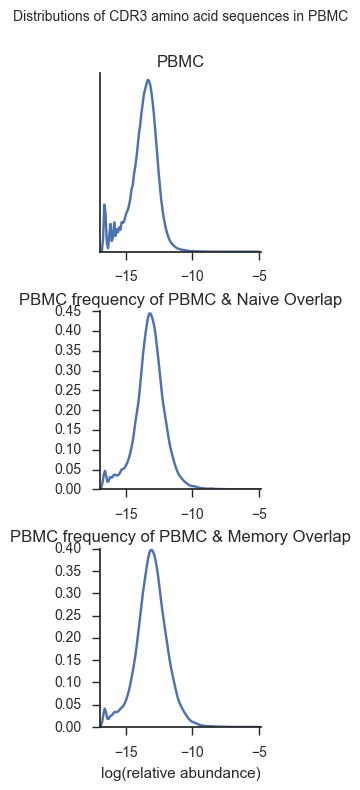

In [181]:
fig = plt.figure(figsize=(3, 8))
plt.suptitle('Distributions of CDR3 amino acid sequences in PBMC')

ax1 = fig.add_subplot(3,1,1)
plt.title('PBMC')
sns.kdeplot(np.log(aa_tbl_pbmc_freq['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
plt.title('PBMC frequency of PBMC & Naive Overlap')
tmp_subtab = aa_tbl_pbmc_freq.loc[aa_tbl_pbmc_freq['aminoAcid'].isin(pbmc_naive_ovrlp)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
plt.title('PBMC frequency of PBMC & Memory Overlap')
tmp_subtab = aa_tbl_pbmc_freq.loc[aa_tbl_pbmc_freq['aminoAcid'].isin(pbmc_mem_ovrlp)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)
plt.xlabel('log(relative abundance)')

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


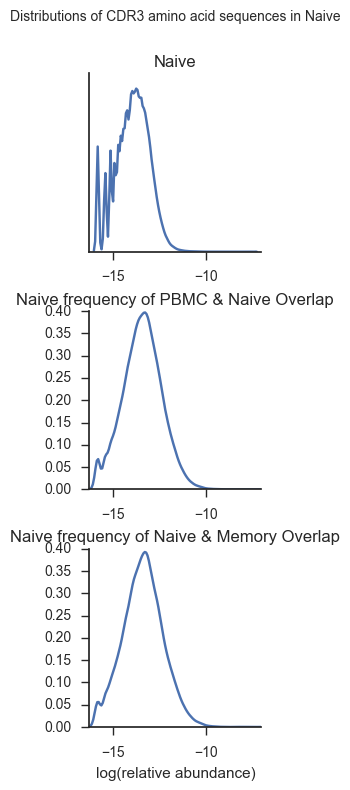

In [182]:
fig = plt.figure(figsize=(3, 8))
plt.suptitle('Distributions of CDR3 amino acid sequences in Naive')

ax1 = fig.add_subplot(3,1,1)
plt.title('Naive')
sns.kdeplot(np.log(aa_tbl_naive_freq['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
plt.title('Naive frequency of PBMC & Naive Overlap')
tmp_subtab = aa_tbl_naive_freq.loc[aa_tbl_naive_freq['aminoAcid'].isin(pbmc_naive_ovrlp)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
plt.title('Naive frequency of Naive & Memory Overlap')
tmp_subtab = aa_tbl_naive_freq.loc[aa_tbl_naive_freq['aminoAcid'].isin(naive_mem_ovrlp)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)
plt.xlabel('log(relative abundance)')

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


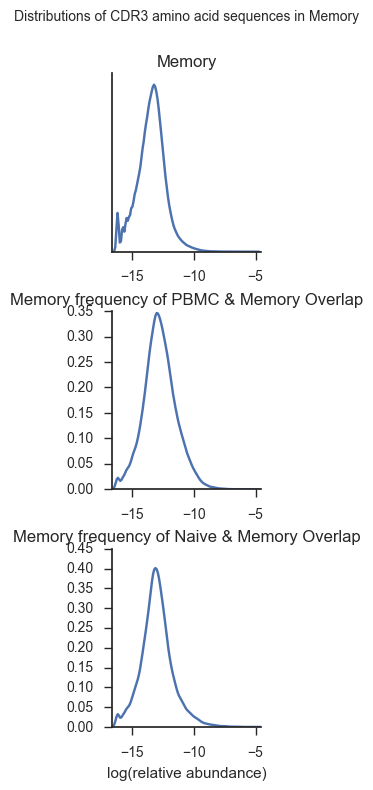

In [183]:
fig = plt.figure(figsize=(3, 8))
plt.suptitle('Distributions of CDR3 amino acid sequences in Memory')

ax1 = fig.add_subplot(3,1,1)
plt.title('Memory')
sns.kdeplot(np.log(aa_tbl_memory_freq['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
plt.title('Memory frequency of PBMC & Memory Overlap')
tmp_subtab = aa_tbl_memory_freq.loc[aa_tbl_memory_freq['aminoAcid'].isin(pbmc_mem_ovrlp)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax2.yaxis.set_visible(False)

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
plt.title('Memory frequency of Naive & Memory Overlap')
tmp_subtab = aa_tbl_memory_freq.loc[aa_tbl_memory_freq['aminoAcid'].isin(naive_mem_ovrlp)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax3.yaxis.set_visible(False)
plt.xlabel('log(relative abundance)')

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)

So there doesn't seem to be any meaningful change in the abundances of TCRs when considering an entire population (like PBMCs) versus the subset of the population that is shared with another T cell population (like Memory cells). This suggests that although Memory cells have supposedly been antagonized at some point in the past, this doesn't really alter their basal abundance when not actively responding to any antigen.

# Variation of the TCR repertoire through time

Now let's start looking at the stability and changes in the TCR repertoire through time in a single patient. We'll first focus on the longer time series of PBMC sampling, and we can later examine Naive and Memory T cells as well.

In [8]:
#make a full table of data, adding the information for the month sampled
time_files = [x for x in glob('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/*PBMC_cl1.tsv')]
pbmc_time = pd.read_csv(time_files[0], sep='\t')
pbmc_time['date'] = time_files[0][59:63] + time_files[0][57:59]
for new_tab in time_files[1:]:
    pbmc_time = pbmc_time.append(pd.read_csv(new_tab, sep='\t'), ignore_index=True)
    pbmc_time = pbmc_time.fillna(new_tab[59:63] + new_tab[57:59])
pbmc_time = pbmc_time.drop('nucleotide', axis=1)
dates = pbmc_time['date'].unique() #list of dates

Summary metrics through time: how do alpha diversity and betadiversity (or percent of overlap) vary with time. How do the most abundant T cells vary through time, does the distribution of TCRs vary? Is the memory or naive subset of samples of PBMCs more or less stable in the far of change over an entire year?

But firstly, what is the overlap between different samples?

In [119]:
dates_num_aa = {x: pbmc_time.loc[pbmc_time['date'] == x]['aminoAcid'].nunique()
                for x in dates}
dates_num_reads = {x: pbmc_time.loc[pbmc_time['date'] == x]['count (templates/reads)'].sum()
                   for x in dates}

In [120]:
overlap_htmp = pd.DataFrame(index=dates, columns=dates)
for i, j in combinations_with_replacement(dates, 2):
    overlap = len(set(pbmc_time.loc[pbmc_time['date'] == i]['aminoAcid']) & 
                  set(pbmc_time.loc[pbmc_time['date'] == j]['aminoAcid']))
    overlap_htmp.set_value(i, j, overlap)
    overlap_htmp.set_value(j, i, overlap)
overlap_htmp = overlap_htmp.apply(pd.to_numeric)

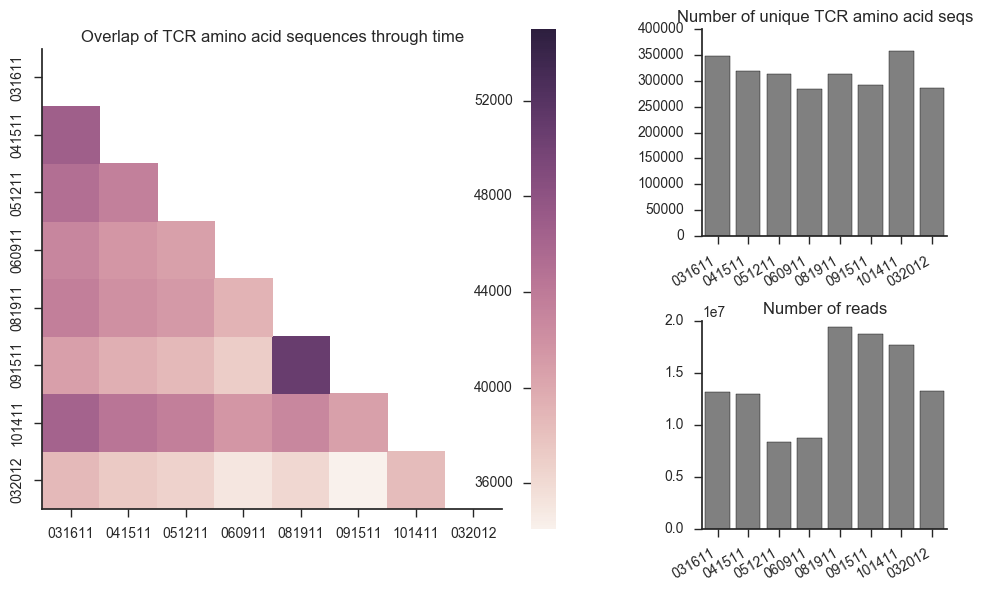

In [49]:
fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
mask = np.zeros_like(overlap_htmp)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(overlap_htmp, mask=mask, square=True, vmax=55000, 
            vmin=None, ax=ax1)
ax1.set_title('Overlap of TCR amino acid sequences through time')

ax2 = plt.subplot2grid((2,3), (0,2))
y = [dates_num_aa[x] for x in dates]
sns.barplot(dates, y, order=dates, ax=ax2, color='grey')
ax2.set_xticklabels(dates, rotation=30, ha='right')
ax2.set_title('Number of unique TCR amino acid seqs')

ax3 = plt.subplot2grid((2,3), (1,2))
y = [dates_num_reads[x] for x in dates]
sns.barplot(dates, y, order=dates, ax=ax3, color='grey')
ax3.set_xticklabels(dates, rotation=30, ha='right')
ax3.set_title('Number of reads')

#fig.autofmt_xdate()
plt.tight_layout()
sns.despine()

And if we look at the percentage of overlap

In [121]:
overlap_htmp_freq = pd.DataFrame(index=dates, columns=dates)
for i, j in combinations_with_replacement(dates, 2):
    freq_share = np.mean((overlap_htmp.get_value(i, j) / dates_num_aa[i],
                          overlap_htmp.get_value(i, j) / dates_num_aa[j]))
    overlap_htmp_freq.set_value(i, j, freq_share)
    overlap_htmp_freq.set_value(j, i, freq_share)
overlap_htmp_freq = overlap_htmp_freq.apply(pd.to_numeric)

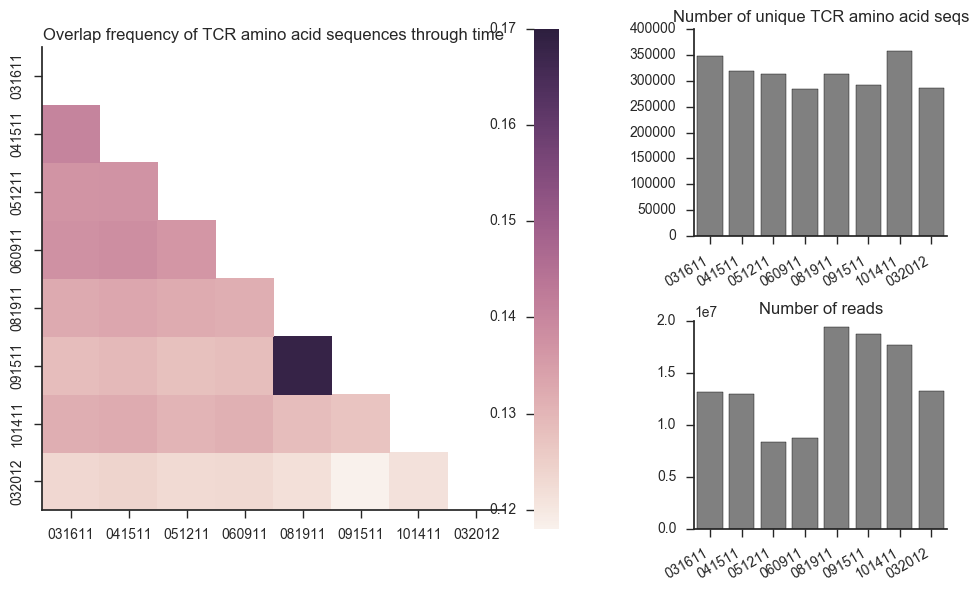

In [123]:
fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((2,3), (0,2))
ax3 = plt.subplot2grid((2,3), (1,2))

mask = np.zeros_like(overlap_htmp_freq)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(overlap_htmp_freq, mask=mask, square=True, vmax=.17, 
            vmin=None, ax=ax1)
ax1.set_title('Overlap frequency of TCR amino acid sequences through time')

y = [dates_num_aa[x] for x in dates]
sns.barplot(dates, y, order=dates, ax=ax2, color='grey')
ax2.set_xticklabels(dates, rotation=30, ha='right')
ax2.set_title('Number of unique TCR amino acid seqs')

y = [dates_num_reads[x] for x in dates]
sns.barplot(dates, y, order=dates, ax=ax3, color='grey')
ax3.set_xticklabels(dates, rotation=30, ha='right')
ax3.set_title('Number of reads')

plt.tight_layout()
sns.despine()

So there are two observable patterns in this data:

1. There is temporal structure in the data, dates closer together in time tend to have more overlap in TCR repertoire
2. One date pair (from August and September of the same year) had 25% higher overlap than the other 1 month samples. This number doesn't look entirely attributable to increased number of reads or number or amino acid sequences found. These samples were 2/3 of the samples that had 3 populations tested (PBMC, Naive, Memory), which might have something to do with it.

Let's look at the frequency distributions of each sample to see if we see anything odd.

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


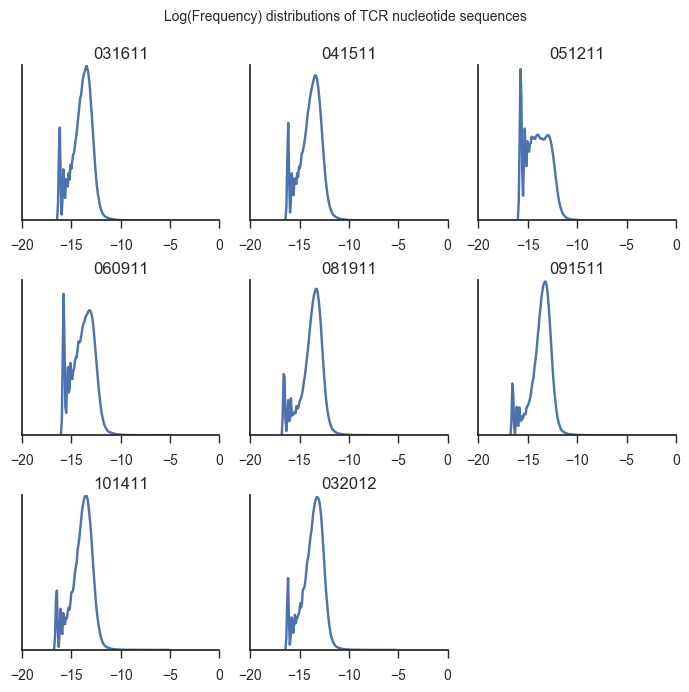

In [59]:
fig = plt.figure(figsize=(7, 7))
plt.suptitle('Log(Frequency) distributions of TCR nucleotide sequences')

ax1 = fig.add_subplot(3,3,1)
plt.title('031611')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '031611']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(3,3,2, sharex=ax1)
plt.title('041511')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '041511']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax2.yaxis.set_visible(False)

ax3 = fig.add_subplot(3,3,3, sharex=ax1)
plt.title('051211')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '051211']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax3.yaxis.set_visible(False)

ax4 = fig.add_subplot(3,3,4, sharex=ax1)
plt.title('060911')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '060911']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax4.yaxis.set_visible(False)

ax5 = fig.add_subplot(3,3,5, sharex=ax1)
plt.title('081911')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '081911']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax5.yaxis.set_visible(False)

ax6 = fig.add_subplot(3,3,6, sharex=ax1)
plt.title('091511')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '091511']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax6.yaxis.set_visible(False)

ax7 = fig.add_subplot(3,3,7, sharex=ax1)
plt.title('101411')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '101411']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax7.yaxis.set_visible(False)

ax8 = fig.add_subplot(3,3,8, sharex=ax1)
plt.title('032012')
tmp_tab = pbmc_time.loc[pbmc_time['date'] == '032012']
sns.kdeplot(np.log(tmp_tab['frequencyCount (%)'].values))
ax8.yaxis.set_visible(False)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

Most of the samples look pretty decent; the May samples looks the worst. The samples with the great number of reads appear to have fewer errors in them, which could mean that the library coverage was better So then what's going on between the August and September samples? I'm assuming that it's just random chance, but it could be a unified response to some sort of antigen or illness during that period.

Let's try to parse out what TCRs are the ones that are shared, and where they fall in the overall distribution.

In [50]:
core_tcrs = set.intersection(*[set(sub_tab['aminoAcid'].unique()) 
                              for name, sub_tab in pbmc_time.groupby('date')])
print(len(core_tcrs))

9902


/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


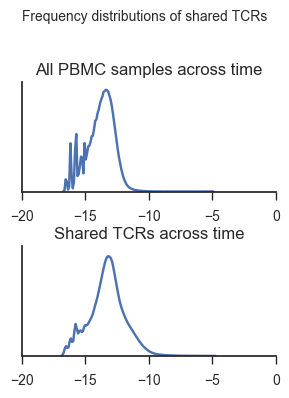

In [65]:
fig = plt.figure(figsize=(3, 4))
plt.suptitle('Frequency distributions of shared TCRs')

ax1 = fig.add_subplot(2,1,1)
plt.title('All PBMC samples across time')
sns.kdeplot(np.log(pbmc_time['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
plt.title('Shared TCRs across time')
tmp_subtab = pbmc_time.loc[pbmc_time['aminoAcid'].isin(core_tcrs)]
sns.kdeplot(np.log(tmp_subtab['frequencyCount (%)'].values))
ax2.yaxis.set_visible(False)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.8)

So at a global level, TCRs that are shared across all samples do seem to remove a lot of the errors that we observe at the rare end of the spectrum, but their distribution looks pretty equivalent to the overall distribution. BUT so far the distributions I've been lookig at here don't account for presence/absense. This might be different.

A method that would probably be useful is to measure the change in an individual TCR, i.e. whether a TCR's position in the distribution shifted. Such a method would start to explore not only the compostition fluctuations through time in the TCR, but also the abundance variations.

Does frequency of TCRs even matter?

Are memory TCRs more likely to be reliably present through time? (I think yes)

But let's first look at alpha diversity over time, which is likely to be very stable.

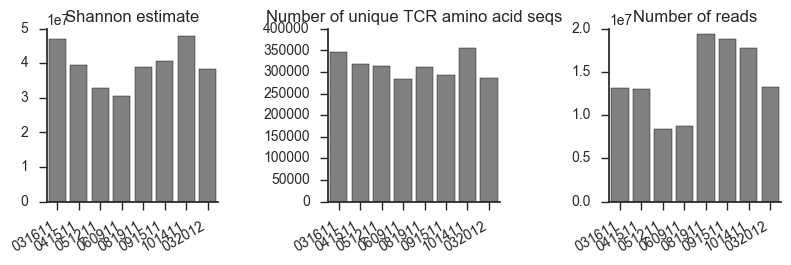

In [8]:
fig = plt.figure(figsize=(8, 3))

ax1 = fig.add_subplot(1,3,1)
y = [exp(div.alpha.shannon(pbmc_time.loc[pbmc_time['date'] == x]['count (templates/reads)'].values)) for x in dates]
sns.barplot(dates, y, order=dates, ax=ax1, color='grey')
ax1.set_xticklabels(dates, rotation=30, ha='right')
ax1.set_title('Shannon estimate')

ax2 = fig.add_subplot(1,3,2)
y = [dates_num_aa[x] for x in dates]
sns.barplot(dates, y, order=dates, ax=ax2, color='grey')
ax2.set_xticklabels(dates, rotation=30, ha='right')
ax2.set_title('Number of unique TCR amino acid seqs')

ax3 = fig.add_subplot(1,3,3)
y = [dates_num_reads[x] for x in dates]
sns.barplot(dates, y, order=dates, ax=ax3, color='grey')
ax3.set_xticklabels(dates, rotation=30, ha='right')
ax3.set_title('Number of reads')

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.8)

So alpha diversity is somewhat more variable than I would have expected, and it doesn't look like this is an artifact of sequencing depth. Is this sampling noise? The two samples that had the most overlap don't have the smallest alpha diversity (which might suggest a clonal expansion).

Let's examine the cells captured from the memory population. If a TCR is in the memory population, is it more likely to be in the PBMC population than a TCR not in the memory compartment?

In [9]:
memory_files = [x for x in glob('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/*Memory_cl1.tsv')]
memory_time = pd.read_csv(memory_files[0], sep='\t')
memory_time['date'] = memory_files[0][59:63] + memory_files[0][57:59]
for new_tab in memory_files[1:]:
    memory_time = memory_time.append(pd.read_csv(new_tab, sep='\t'), ignore_index=True)
    memory_time = memory_time.fillna(new_tab[59:63] + new_tab[57:59])
memory_time = memory_time.drop('nucleotide', axis=1)
memory_dates = memory_time['date'].unique() #list of dates

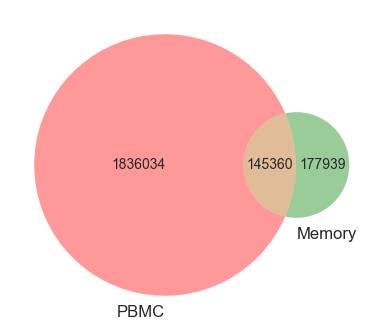

In [14]:
plt_venn.venn2([set(pbmc_time['aminoAcid']), set(memory_time['aminoAcid'])],
              set_labels=('PBMC', 'Memory'))

So looking over all sampled time points for PBMCs, about 45% of memory TCRs are observed at some point in the PBMC dataset. That's much larger than the 22% overlap found between samples from the same time point, indicating that a large portion of potential overlap is contributed by the more comprehensive sampling acquired over time. This might be a result of simply using more blood samples to sequences the TCR, but let's see if this pattern is stable in time.

To look at this, we can first look at what fraction of memory TCRs occur in multiple PBMC samples and compare that to all PBMC TCRs overall. The only problem with this is that so called "memory TCRs" in the PBMC samples will be depleted of errorneous TCR sequences because of sample-to-sample comparisons (i.e., the TCR has to now be present in both Memory and PBMC samples, decreasing the number of TCR errors). The best way to create a null model here is probably to shuffle the labels, and see if the results change.

In [46]:
memory_aa = set(memory_time['aminoAcid'])
mem_pbmc_overlap = memory_aa & set(pbmc_time['aminoAcid'])
#For each pbmc sampling date, split the TCRs into memory or other
#Does this help predict whether a TCR will be present in the future?
tcr_sample_dict = defaultdict(int) #store the number of samples each TCR occurs in
for date, table in pbmc_time.groupby('date'):
    for tcr in table['aminoAcid'].unique():
        tcr_sample_dict[tcr] += 1
mem_overlap_recurrence = sum(tcr_sample_dict[x] >= 2 for x in mem_pbmc_overlap) / len(tcr_sample_dict)
print(mem_overlap_recurrence)
overall_recurrence = sum(x >= 2 for x in tcr_sample_dict.values()) / len(tcr_sample_dict)
print(overall_recurrence)

0.04713802504701236
0.12969909064022603


The fact that the overlap between the memory and PBMC populations is less stable in the PBMC samples disproves my hypothesis that memory cells might have a more durable presense in TCR repertoire read out. Again, it looks like the extreme diversity in these samples is the norm, meaning that samples that are handled uniformly (like the PBMC samples) are more likely to resemble one another than samples that come from a different protocol (like the memory cells).

Can we eliminate some of the erroneous TCR sequences by filtering for TCRs found in multiple samples? How does this affect the distribution of TCRs?

In [66]:
pbmc_time_n2 = adaptive_error_filter(pbmc_time, 'date', num_samples=2)
pbmc_time_n4 = adaptive_error_filter(pbmc_time, 'date', num_samples=4)

In [23]:
print(pbmc_time.shape)
print(pbmc_time_n2.shape)
print(pbmc_time_n4.shape)

(2868829, 7)
(2475058, 7)
(2420494, 7)


/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


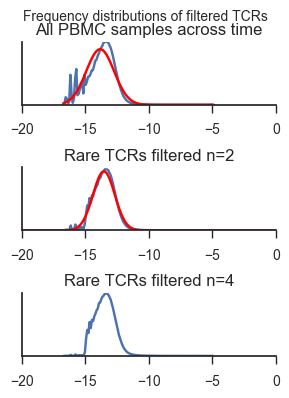

In [67]:
fig = plt.figure(figsize=(3, 4))
plt.suptitle('Frequency distributions of filtered TCRs')

ax1 = fig.add_subplot(3,1,1)
plt.title('All PBMC samples across time')
sns.kdeplot(np.log(pbmc_time['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(np.log(pbmc_time['frequencyCount (%)'].values)) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red')

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
plt.title('Rare TCRs filtered n=2')
sns.kdeplot(np.log(pbmc_time_n2['frequencyCount (%)'].values))
ax2.yaxis.set_visible(False)
mu, std = norm.fit(np.log(pbmc_time_n2['frequencyCount (%)'].values)) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red')

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
plt.title('Rare TCRs filtered n=4')
sns.kdeplot(np.log(pbmc_time_n4['frequencyCount (%)'].values))
ax3.yaxis.set_visible(False)

plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)

So it looks like this criteria is not entirely appropriate, and mostly just cuts off the tail end of the distribution. This makes sense, since these TCR sequences are so rare that it would be very unlikely that they would be shared across samples. For certain analyses, this cutting of true positives might be better than retaining the false positives. However, removing these rare TCRs does improve the fit of a normal distribution, since it is no longer trying to fit the errant sequences.

As a side note, apparantly "spectratype" means the length of a given individual or population of TCRs.

One might wonder if errors in the nucleotide sequence (but not the amino acid sequence or mapping to V and J segements) is contributing to the errors. What happens if we collapse different nucleotides?

In [34]:
pbmc_time_ncollapse = df_collapse(pbmc_time, ['vMaxResolved', 'jMaxResolved', 'aminoAcid', 'date'],
                                 ['count (templates/reads)', 'frequencyCount (%)'])

In [35]:
print(pbmc_time.shape)
print(pbmc_time_ncollapse.shape)

(2868829, 7)
(2718933, 6)


/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


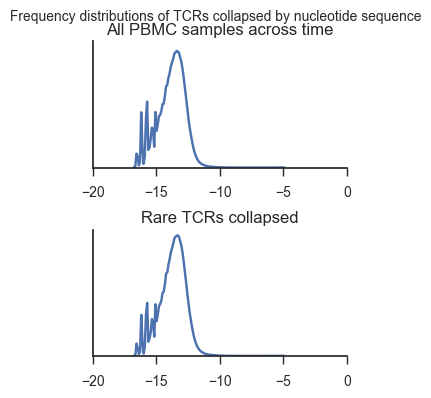

In [39]:
fig = plt.figure(figsize=(3, 4))
plt.suptitle('Frequency distributions of TCRs collapsed by nucleotide sequence')

ax1 = fig.add_subplot(2,1,1)
plt.title('All PBMC samples across time')
sns.kdeplot(np.log(pbmc_time['frequencyCount (%)'].values))
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
plt.title('Rare TCRs collapsed')
sns.kdeplot(np.log(pbmc_time_ncollapse['frequencyCount (%)'].values))
ax2.yaxis.set_visible(False)


plt.tight_layout()
sns.despine()
plt.subplots_adjust(top=0.9)

So that definitely decreased the number of errors to a small degree, the overall distribution is intact, but the errant peaks lower thant exp(-15) are smaller, although still large. We could take this strategy further and try to combine TCRs that have the same aminoAcid and very similar vMAxResolved, which might eliminate some errors in the V allele assignment based on nucleotide sequence, but it doesn't seem like this would make a large difference.

If we look at the TCRs that a present at all time points, what do their dynamics look like? I seems like frequency doesn't really matter, but does the frequency of a durable TCR vary greatly with time?

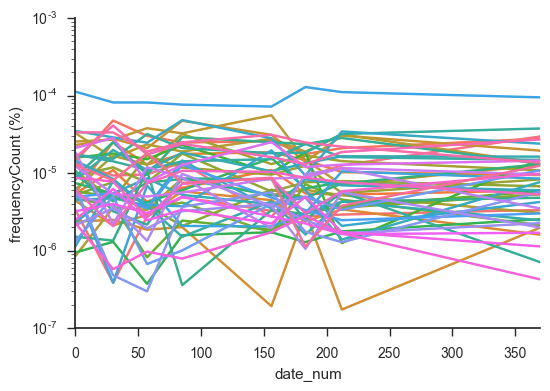

In [107]:
random_core_tcrs = random.sample(core_tcrs, 50)
core_tcr_tab = pbmc_time.loc[pbmc_time['aminoAcid'].isin(random_core_tcrs)]
core_tcr_tab = df_collapse(core_tcr_tab, ['aminoAcid', 'date'], ['frequencyCount (%)'])
#get the number of days to register correctly
core_tcr_tab['date'] = pd.to_datetime(core_tcr_tab['date'], format='%m%d%y')
core_tcr_tab['date_num'] = (core_tcr_tab['date'] - pd.datetime(2011, 3,16)).dt.days
sns.tsplot(core_tcr_tab, time='date_num', value='frequencyCount (%)', 
           condition='aminoAcid', unit='aminoAcid', legend=False)
plt.yscale('log')
sns.despine()

So in the durable "core" TCR repertoire, the abundances are pretty stable. We could look for the extent that these patterns are autoregressive (i.e., the abundance at point t predicts the abundance at point t+1, but this seems kinda silly for a system where the overall turnover from sample to sample is over 80%.

Do more abundant TCRs tend to be more durable across time?

Also, let's start looking at TCR epitopes, defined as unique combinations of V, J, and CDR3 sequences.

In [15]:
#get TCR epitopes
pbmc_time, pbmc_tcr_ep_dict = col_comb_rename(pbmc_time, 
                                   ['vMaxResolved', 'jMaxResolved', 'aminoAcid'],
                                  id_col='tcr_epitope', drop=False)

In [20]:
#plot avg abundance versus number of time points, add data to the table
tcr_mean_freq = []
tcr_num_dates = []
tcr_mean_freq = {} #get this for new column in data table
tcr_num_dates_dict = {} #get this to add new column to tidy data table
for tcr, sub_df in pbmc_time[['frequencyCount (%)', 'date', 'tcr_epitope']].groupby('tcr_epitope'):
    mean_freq = sub_df['frequencyCount (%)'].mean()
    tcr_mean_freq.append(mean_freq)
    num_dates = sub_df['date'].nunique()
    tcr_num_dates.append(num_dates)
    tcr_mean_freq[tcr] = mean_freq
    tcr_num_dates_dict[tcr] = num_dates
pbmc_time['tcr_ep_numsamp'] = pbmc_time['tcr_epitope'].apply(lambda x : tcr_num_dates_dict[x])
pbmc_time['tcr_ep_mean']

In [24]:
#write data table to save TCR epitopes and numbers of samples per epitope
pbmc_time.to_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01_timecourse_pbmc.txt',
                sep='\t', index=False)

In [3]:
#read new table for new instance
pbmc_time = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/Subject01_timecourse_pbmc.txt',
                sep='\t')

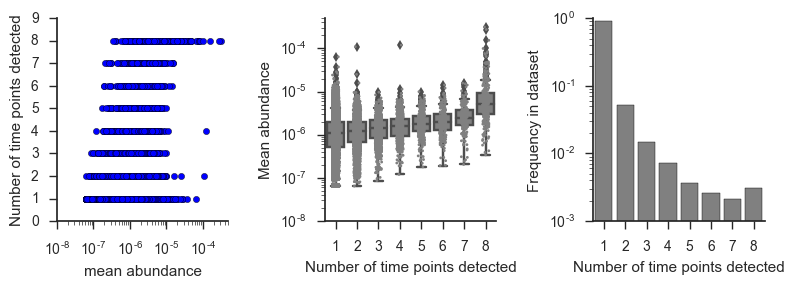

In [51]:
subsample = random.sample(list(zip(tcr_mean_freq, tcr_num_dates)), 100000)
fig = plt.figure(figsize=(8, 3))

ax1 = fig.add_subplot(1,3,1)
plt.scatter([z[0] for z in subsample], [z[1] for z in subsample])
plt.xlabel('mean abundance')
plt.ylabel('Number of time points detected')
plt.xlim(.00000001, .0005)
plt.xscale('log')

ax2 = fig.add_subplot(1,3,2)
sns.stripplot(x=[z[1] for z in subsample], y=[z[0] for z in subsample], jitter=.15, size=2,
             color='grey')
sns.boxplot(x=[z[1] for z in subsample], y=[z[0] for z in subsample], color='grey')
plt.xlabel('Number of time points detected')
plt.ylabel('Mean abundance')
plt.ylim(.00000001, .0005)
plt.yscale('log')

ax3 = fig.add_subplot(1,3,3)
tcr_num_counter = Counter([z[1] for z in subsample])
tcr_num_counter = tcr_num_counter.items()
sns.barplot(x=[z[0] for z in tcr_num_counter], y=[z[1]/100000 for z in tcr_num_counter],
           color='grey')
plt.xlabel('Number of time points detected')
plt.ylabel('Frequency in dataset')
plt.yscale('log')

plt.tight_layout()
sns.despine()

So it does look like abundance has some bearing on the presense of each TCR epitope across multiple samples through time. The biological relevance of this pattern is debatable, but it fits a story that some subset of TCRs tend to be maintained at a higher titer, while others are at such low abundance as to fall in and out of detection. These higher titer TCRs may represent TCRs that respond to commonly encountered antigen, like those from common pathogens (e.g., cold, CMV) or even resident microbiota members. How to prove that this isn't just noise?

Furthermore, a larger and perhaps more interesting pattern to obeserve here is that even TCRs that only show up in one sample (i.e., they are only present for a fleeting time) can have a huge range of abundances, suggesting that the dynamic range of a given TCR epitope can be highly variable.

So like the microbiome, I'm guessing that interindividual differences will be huge, and intraindividual differences are also very large. It's interesting that there are more TCRs present in all 8 samples than present in only 7 samples, further suggesting that some nonrandom portion of the TCR repertoire is durable through time. **Does this pattern hold across people?**

In [4]:
x_tmp = pbmc_time.loc[pbmc_time['date'] == 31611].set_index('tcr_epitope')['frequencyCount (%)']
x_tmp = x_tmp.groupby(x_tmp.index).sum()
y_tmp = pbmc_time.loc[pbmc_time['date'] == 41511].set_index('tcr_epitope')['frequencyCount (%)']
y_tmp = y_tmp.groupby(y_tmp.index).sum()

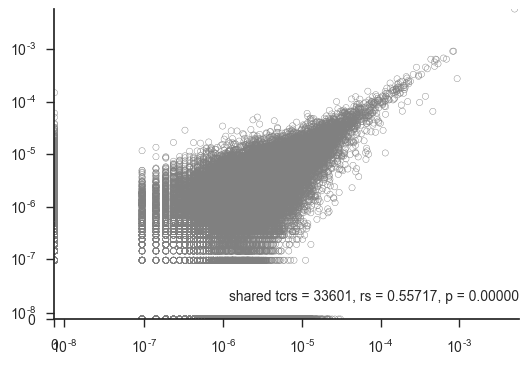

In [12]:
plot_freq_comparison(x_tmp, y_tmp, return_axes=False)

This should have corresponding KDE plots on the axes

In [13]:
y_tmp = pbmc_time.loc[pbmc_time['date'] == 32012].set_index('tcr_epitope')['frequencyCount (%)']
y_tmp = y_tmp.groupby(y_tmp.index).sum()

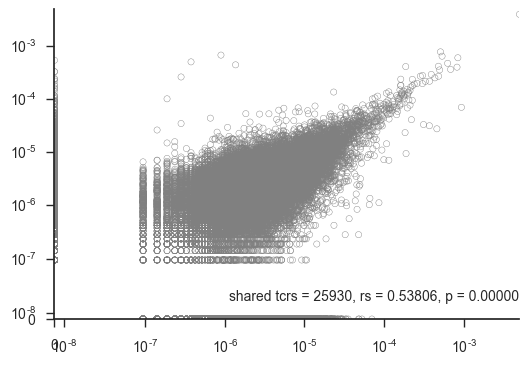

In [14]:
plot_freq_comparison(x_tmp, y_tmp, return_axes=False)

Here we can see that in the same individual, we see a surprising amount of linearity from month to month, and across an entire year.

##  TCR Null Model

In this null model, we will assume that the number of possible TCR sequences is the total number of unique TCRs in whatever dataset is under consideration. In the case of the time series data, it is the number of unique TCRs oberserved over all time points (2,335,630). We then assume that all TCRs have a random probability P of appearing in any given samples, and this P is the same for all TCRs across all time points. Within each time point, use a normal distribution to model the log abudnances of each TCR. 

How well does a normal distribution fit the log data? And how do we correct for the likely errors at the low end of the spectrum?

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


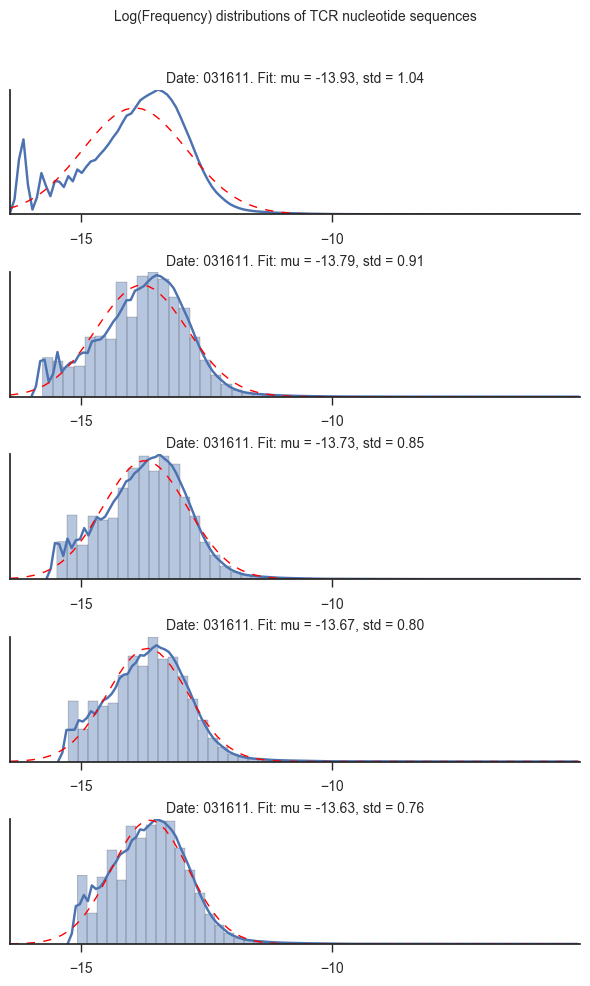

In [117]:
fig = plt.figure(figsize=(6, 10))
plt.suptitle('Log(Frequency) distributions of TCR nucleotide sequences')

ax1 = fig.add_subplot(5,1,1)
tmp_tab = pbmc_time_ep.loc[pbmc_time_ep['date'] == '031611']
freq_data = np.log(tmp_tab['frequencyCount (%)'].values)
sns.kdeplot(freq_data) #plot kde of data
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(np.log(tmp_tab['frequencyCount (%)'].values)) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red', ls='dashed', lw=1)
plt.title('Date: 031611. Fit: mu = %.2f, std = %.2f' % (mu, std), fontsize=10)

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
tmp_tab = tmp_tab.loc[tmp_tab['count (templates/reads)'] > 2]
freq_data_filter = np.log(tmp_tab['frequencyCount (%)'].values)
sns.distplot(freq_data_filter) #plot kde of data
ax2.yaxis.set_visible(False)
ax2.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(freq_data_filter) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red', ls='dashed', lw=1)
plt.title('Date: 031611. Fit: mu = %.2f, std = %.2f' % (mu, std), fontsize=10)

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
tmp_tab = tmp_tab.loc[tmp_tab['count (templates/reads)'] > 3]
freq_data_filter = np.log(tmp_tab['frequencyCount (%)'].values)
sns.distplot(freq_data_filter) #plot kde of data
ax3.yaxis.set_visible(False)
ax3.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(freq_data_filter) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red', ls='dashed', lw=1)
plt.title('Date: 031611. Fit: mu = %.2f, std = %.2f' % (mu, std), fontsize=10)

ax4 = fig.add_subplot(5,1,4, sharex=ax1)
tmp_tab = tmp_tab.loc[tmp_tab['count (templates/reads)'] > 4]
freq_data_filter = np.log(tmp_tab['frequencyCount (%)'].values)
sns.distplot(freq_data_filter) #plot kde of data
ax4.yaxis.set_visible(False)
ax4.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(freq_data_filter) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red', ls='dashed', lw=1)
plt.title('Date: 031611. Fit: mu = %.2f, std = %.2f' % (mu, std), fontsize=10)

ax5 = fig.add_subplot(5,1,5, sharex=ax1)
tmp_tab = tmp_tab.loc[tmp_tab['count (templates/reads)'] > 5]
freq_data_filter = np.log(tmp_tab['frequencyCount (%)'].values)
sns.distplot(freq_data_filter) #plot kde of data
ax5.yaxis.set_visible(False)
ax5.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(freq_data_filter) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red', ls='dashed', lw=1)
plt.title('Date: 031611. Fit: mu = %.2f, std = %.2f' % (mu, std), fontsize=10)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So by removing TCRs that have very low numbers of counts, we continually imporve the fit of a normal distribution to the data, but how much is too much? Removing the 2s makes a lot of sense, since they were orphaned in the data. Do we need to find a different distribution? They all look pretty normal. Let's try out eliminating all TCRs with < 4 counts (keeping ones with 4) for the purposes of establishing a null model. As a first step, let's test whether the pattern of finding a durable core TCR holds up to this condition of setting a minimum number of counts.

In [28]:
pbmc_time_n4 = pbmc_time.loc[pbmc_time['count (templates/reads)'] > 3]

In [44]:
pbmc_n4_mean_freq = pbmc_time_n4.groupby('tcr_epitope')['frequencyCount (%)'].mean().to_frame() #frequency values
tmp = pbmc_time_n4[['tcr_epitope', 'tcr_ep_numsamp']]
pbmc_n4_num_sam = tmp[~tmp['tcr_epitope'].duplicated(keep='first')].set_index('tcr_epitope')
tmp = pd.concat([pbmc_n4_mean_freq, pbmc_n4_num_sam], axis=1)
pbmc_n4_mean_freq = tmp['frequencyCount (%)'].values
pbmc_n4_num_sam = tmp['tcr_ep_numsamp'].values

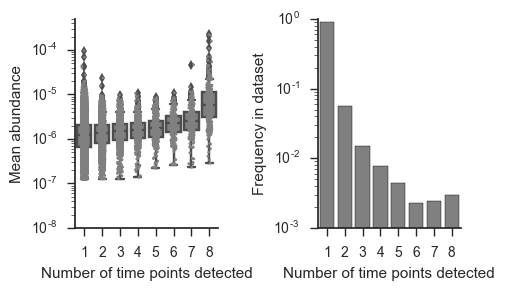

In [45]:
subsample = random.sample(list(zip(pbmc_n4_mean_freq, pbmc_n4_num_sam)), 100000)
fig = plt.figure(figsize=(5, 3))

ax2 = fig.add_subplot(1,2,1)
sns.stripplot(x=[z[1] for z in subsample], y=[z[0] for z in subsample], jitter=.15, size=2,
             color='grey')
sns.boxplot(x=[z[1] for z in subsample], y=[z[0] for z in subsample], color='grey')
plt.xlabel('Number of time points detected')
plt.ylabel('Mean abundance')
plt.ylim(.00000001, .0005)
plt.yscale('log')

ax3 = fig.add_subplot(1,2,2)
tcr_num_counter = Counter([z[1] for z in subsample])
tcr_num_counter = tcr_num_counter.items()
sns.barplot(x=[z[0] for z in tcr_num_counter], y=[z[1]/100000 for z in tcr_num_counter],
           color='grey')
plt.xlabel('Number of time points detected')
plt.ylabel('Frequency in dataset')
plt.yscale('log')

plt.tight_layout()
sns.despine()

So if we cut out all of the epitopes that occur fewer than 4 times, the data looks the same. Now let's look at what our expectation would be given our null model. In this new dataset, we have 2,162,056 TCR epitopes, and a null model normal distribution of log(abundances) that looks like this:

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


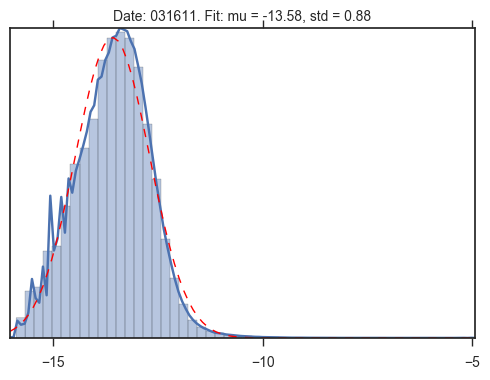

In [50]:
tmp = pbmc_time_n4.groupby(['date', 'tcr_epitope'])['frequencyCount (%)'].sum()
freq_data = np.log(tmp.values)
ax1 = sns.distplot(freq_data) #plot kde of data
ax1.yaxis.set_visible(False)
ax1.locator_params(axis='x', tight=True, nbins=5)
mu, std = norm.fit(freq_data) #fit normal
xmin, xmax = plt.xlim() #plot the pdf of the normal distribution
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color='red', ls='dashed', lw=1)
plt.title('Date: 031611. Fit: mu = %.2f, std = %.2f' % (mu, std), fontsize=10)

Which fits prety darn well. So now we can simulate our data using our normal distribution and our TCR assumptions (that any TCR is equally likely to appear at any time point). An additional assumption will be that each sample (here meaning date) will have an equal number of TCR epitopes, which seems reasonable given that the original data was very close to this. 

Let's simulate this for 

In [54]:
tcrs_time = [random.sample(range(1, 2162056), 325000)] #this is the wrong way to do this
#I'm not sure what the proper Null model is. Will need to discuss
#let do other things in the meantime.

### Discussion with Sean Gibbons on May 17, 2017

Points to consider:
* Quantify qutocorrelation
    * Mantel's test or Moran's I
    * Half-lifes of various TCRs
* Examine the core TCR repertoire more closely
    * Do any exhibit particularly interesting dynamics?
    * Do any extend across individuals?
* Break point analysis
    * Are there any large shifts in the TCR repertoire structure?
* Stationarity
    * Are frequencies stationary in different T cell types or subpopulations?
* Bin TCRs based on their variance or their means